In [64]:
import pandas as pd
from binance.client import Client
from Binance_api import api_key, secret_key
from datetime import datetime
from datetime import timedelta
import time
from binance.exceptions import BinanceAPIException
import pandas as pd
import numpy as np
import os
from binance.client import Client
from Binance_api import api_key, secret_key
import time
import plotly.graph_objects as go
import talib as ta
from datetime import datetime
import os
from ta import add_all_ta_features
import warnings
import sklearn
from sklearn.decomposition import PCA
import plotly.express as px
import numpy
import plot_utils 
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
import plotly.express as px
warnings.filterwarnings('ignore')
client = Client(api_key, secret_key,tld='us')
rsi = 0
bottoms_5 = [9999999,99999999,99999999,99999999,9999999]
rsi_l = [9999999,99999999,99999999,99999999,9999999]
buy = 0
sell = 0

In [56]:
df = pd.read_csv('BTC_15min_10JAN.csv')

In [57]:
def sma(data, window): 
    return(data.rolling(window = window).mean())

def bollinger_band(data, sma, window, nstd):
    std = data.rolling(window = window).std()
    upper_band = sma + std * nstd
    lower_band = sma - std * nstd
    return upper_band, lower_band
symbols = ['BTC']

nstd = 3
def rsi(symbol, i):
    if df[f'{symbol}_rsi'].iloc[i] > rsi:
        rsi = df[f'{symbol}_rsi'].iloc[i]
    return rsi

def get_rsi(close, periods, ema):
  """
    Returns a pd.Series with the relative strength index.
    """
  close_delta = close.diff()

  # Make two series: one for lower closes and one for higher closes
  up = close_delta.clip(lower=0)
  down = -1 * close_delta.clip(upper=0)

  if ema == True:
    # Use exponential moving average
    ma_up = up.ewm(com=periods - 1, adjust=True, min_periods=periods).mean()
    ma_down = down.ewm(com=periods - 1, adjust=True,
                       min_periods=periods).mean()
  else:
    # Use simple moving average
    ma_up = up.rolling(window=periods).mean()
    ma_down = down.rolling(window=periods).mean()

  rsi = ma_up / ma_down
  rsi = 100 - (100 / (1 + rsi))
  return rsi

def bottoms(new_bottom,rsi_new,bottoms_5,rsi_l):
    is_new = 0
    for a in range(len(bottoms_5)):
        if new_bottom < bottoms_5[a]:
            is_new = 1
    if is_new == 1:
        br = len(bottoms_5) - 1
        while br > 0:
            bottoms_5[br] = bottoms_5[br-1]
            rsi_l[br] = rsi_l[br-1]
            br -= 1
        br = new_bottom
        rsi_l[0] = rsi_new
    return bottoms_5, rsi_l


def divergence(bottoms_5,rsi_l,df,i):
    low_n = 0
    for a in range(len(bottoms_5)):
        if df[f'{symbol}-USD_Close'].iloc[i] < bottoms_5[a] and df[f'{symbol}_rsi'].iloc[i] > rsi_l[a]:
            low_n =+ 1 
    if low_n > 0:
        return True

def div(df,i):
    p = i - 1
    d = 0
    while p > i-20:
        if df[f'{symbol}_rsi'].iloc[p] > 70:
            return False
        p = p - 1 
    p = i - 1
    while p > i-150:
        if df[f'{symbol}-USD_Close'].iloc[p] < df[f'{symbol}_lower_band'].iloc[p]:
            if df[f'{symbol}-USD_Close'].iloc[i] < df[f'{symbol}-USD_Close'].iloc[p] and df[f'{symbol}_rsi'].iloc[i] > df[f'{symbol}_rsi'].iloc[p] + 3:
                d = d + 1
        p = p - 1 
    if d > 2:
        return True 
    else: 
        return False

def div2(df,i,last_candle_buy):
    p = i - 2
    while p > last_candle_buy:
        if df[f'{symbol}-USD_Close'].iloc[p] > df[f'{symbol}_upper_band'].iloc[p]:
            if df[f'{symbol}-USD_Close'].iloc[i] > df[f'{symbol}-USD_Close'].iloc[p] and df[f'{symbol}_rsi'].iloc[i] < df[f'{symbol}_rsi'].iloc[p]:
                return True
        p = p - 1 

for symbol in symbols:
    df[f'{symbol}_sma'] = sma(df[f'{symbol}-USD_Open'],20)
    df[f'{symbol}_upper_band'], df[f'{symbol}_lower_band'] = bollinger_band(df[f'{symbol}-USD_Open'], df[f'{symbol}_sma'], 20, nstd)       
    df[f'{symbol}_rsi'] = get_rsi(df[f'{symbol}-USD_Close'],periods=14,ema=True) 
    df[f'{symbol}_ema'] = df[f'{symbol}-USD_Open'].ewm(span=200).mean()
    #df[f'{symbol}_rsi'] = ta.RSI(df[f'{symbol}-USD_Close'])

        
df.dropna(inplace=True)

In [58]:
class TradingEnv:
    def __init__(self, balance_amount, balance_unit, trading_fee_multiplier):
        self.balance_amount = balance_amount
        self.balance_unit = balance_unit
        self.buys = []
        self.sells = []
        self.trading_fee_multiplier = trading_fee_multiplier
        
    def buy(self, symbol, buy_price, time):
        self.balance_amount = (self.balance_amount / buy_price) * self.trading_fee_multiplier
        self.balance_unit = symbol
        self.buys.append([symbol, time, buy_price])
        
    def sell(self, sell_price, time):
        self.balance_amount = self.balance_amount * sell_price * self.trading_fee_multiplier
        self.sells.append( [self.balance_unit, time, sell_price] )
        self.balance_unit = 'USDT'

# VIP level 0, paying fees with BNB = 0.075%

        

In [67]:
fig = px.line(df,x='CloseTime', y=['BTC-USD_Close',f'{symbol}_lower_band',f'{symbol}_upper_band',f'{symbol}_ema'])
fig.show()


<AxesSubplot:xlabel='CloseTime'>

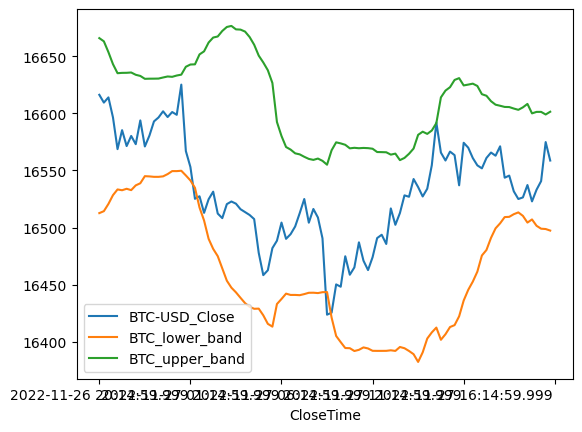

In [41]:
last_10 = df.tail(100)
last_10.plot(x='CloseTime', y=['BTC-USD_Close',f'{symbol}_lower_band',f'{symbol}_upper_band'])

In [31]:
env = TradingEnv(balance_amount=100,balance_unit='USDT', trading_fee_multiplier=1) #0.99925

In [32]:
last_buy = 0
last_buy_candle = 0
for i in range(len(df)):
    if env.balance_unit == 'USDT':
        for symbol in symbols:
            if buy == 0:
                if df[f'{symbol}-USD_Low'].iloc[i] < df[f'{symbol}_lower_band'].iloc[i] and div(df,i):
                    buy = 1
            elif buy == 1 and df[f'{symbol}-USD_Close'].iloc[i] > df[f'{symbol}-USD_Open'].iloc[i]:
                env.buy(symbol, df[f'{symbol}-USD_Close'].iloc[i], df['OpenTime'].iloc[i])
                last_buy = df[f'{symbol}-USD_Close'].iloc[i]
                last_buy_candle = i
                buy = 0
                break

    if env.balance_unit != 'USDT':
        if sell == 0:
            if last_buy*0.9 > df[f'{env.balance_unit}-USD_Close'].iloc[i]:
                env.sell(df[f'{env.balance_unit}-USD_Close'].iloc[i], df['OpenTime'].iloc[i])
            elif df[f'{symbol}-USD_Close'].iloc[i] > df[f'{symbol}_upper_band'].iloc[i] and df[f'{symbol}_rsi'].iloc[i] > 70: #sell signal df[f'{symbol}_rsi'].iloc[i] > 55
                sell = 1
        elif sell == 1 and df[f'{symbol}-USD_Close'].iloc[i] < df[f'{symbol}-USD_Open'].iloc[i]:
            env.sell(df[f'{env.balance_unit}-USD_Close'].iloc[i], df['OpenTime'].iloc[i])
            sell = 0

if env.balance_unit != 'USDT':
    env.sell(df[f'{env.balance_unit}-USD_Close'].iloc[-1], df['OpenTime'].iloc[-1])

In [33]:
print(f'num buys: {len(env.buys)}')
print(f'num sells: {len(env.sells)}')
print('starting balance: 100 USDT')
print(f'ending balance: {env.balance_amount} {env.balance_unit}')


num buys: 68
num sells: 68
starting balance: 100 USDT
ending balance: 109.068848441865 USDT


In [34]:
balance = 100
profit_total = 0
tp = 0
tl = 0
total_profit = 0
total_loss = 0
for i in range(len(env.buys)):
    buys = env.buys[i]
    
    sells = env.sells[i]
    profit = ((sells[2]/buys[2])-1)*100
    print(buys)
    print(sells)
    print('P/L = 'f'{profit}')
    if profit > 0:
        tp = tp + 1
        total_profit = total_profit + profit
    elif profit < 0: 
        tl = tl + 1
        total_loss = total_loss + profit
    balance += balance*(profit/100)
    print(balance)
    print('\n')

    

['BTC', '2022-01-11 00:45:00', 40786.57]
['BTC', '2022-01-12 23:45:00', 43920.97]
P/L = 7.684882548348648
107.68488254834865


['BTC', '2022-01-18 01:15:00', 42624.25]
['BTC', '2022-01-19 07:45:00', 42369.92]
P/L = -0.5966791204537358
107.04234933829753


['BTC', '2022-01-21 22:45:00', 38186.16]
['BTC', '2022-01-24 09:15:00', 36326.69]
P/L = -4.869486745983364
101.82993632467992


['BTC', '2022-01-31 22:45:00', 37081.15]
['BTC', '2022-02-01 01:45:00', 37722.91]
P/L = 1.7306906608883565
103.59229752263971


['BTC', '2022-02-03 07:45:00', 36922.51]
['BTC', '2022-02-04 16:30:00', 37927.02]
P/L = 2.720589689054176
106.41061888769497


['BTC', '2022-02-12 16:15:00', 42158.12]
['BTC', '2022-02-15 11:45:00', 43465.96]
P/L = 3.10222562106659
109.71171637036457


['BTC', '2022-02-18 22:00:00', 40539.09]
['BTC', '2022-02-21 09:00:00', 38712.89]
P/L = -4.504787847975855
104.76943630350665


['BTC', '2022-02-21 21:00:00', 38296.22]
['BTC', '2022-02-23 18:30:00', 38723.25]
P/L = 1.1150708868917114


In [1425]:
win_rate = tp/(tp+tl)
average_win = total_profit/tp
average_loss = total_loss/tl
EV = (average_win*win_rate) + (average_loss*(1-win_rate))
print('total winning trades = 'f'{tp}')
print('total losing trades = 'f'{tl}')
print('win rate = 'f'{win_rate}')
print('average make on trade = 'f'{average_win}')
print('average loss on trade = 'f'{average_loss}')
print('Expected Return Per Trade = 'f'{EV}')

total winning trades = 65
total losing trades = 206
win rate = 0.23985239852398524
average make on trade = 3.1257011414077946
average loss on trade = -0.8457593318759415
Expected Return Per Trade = 0.10680498828436424


In [1348]:
a = [1,6,5,3]
x = 8

b = len(a) - 1
while b > 0:
    a[b] = a[b-1]
    b -= 1
a[0] = x


    
